In [63]:

import numpy as np
import matplotlib.pyplot as plt
import random
import time
STARTING = -2
FINISHING = 1
TRACK = -1
EPSILON = 0.7
GAMMA = 0.9

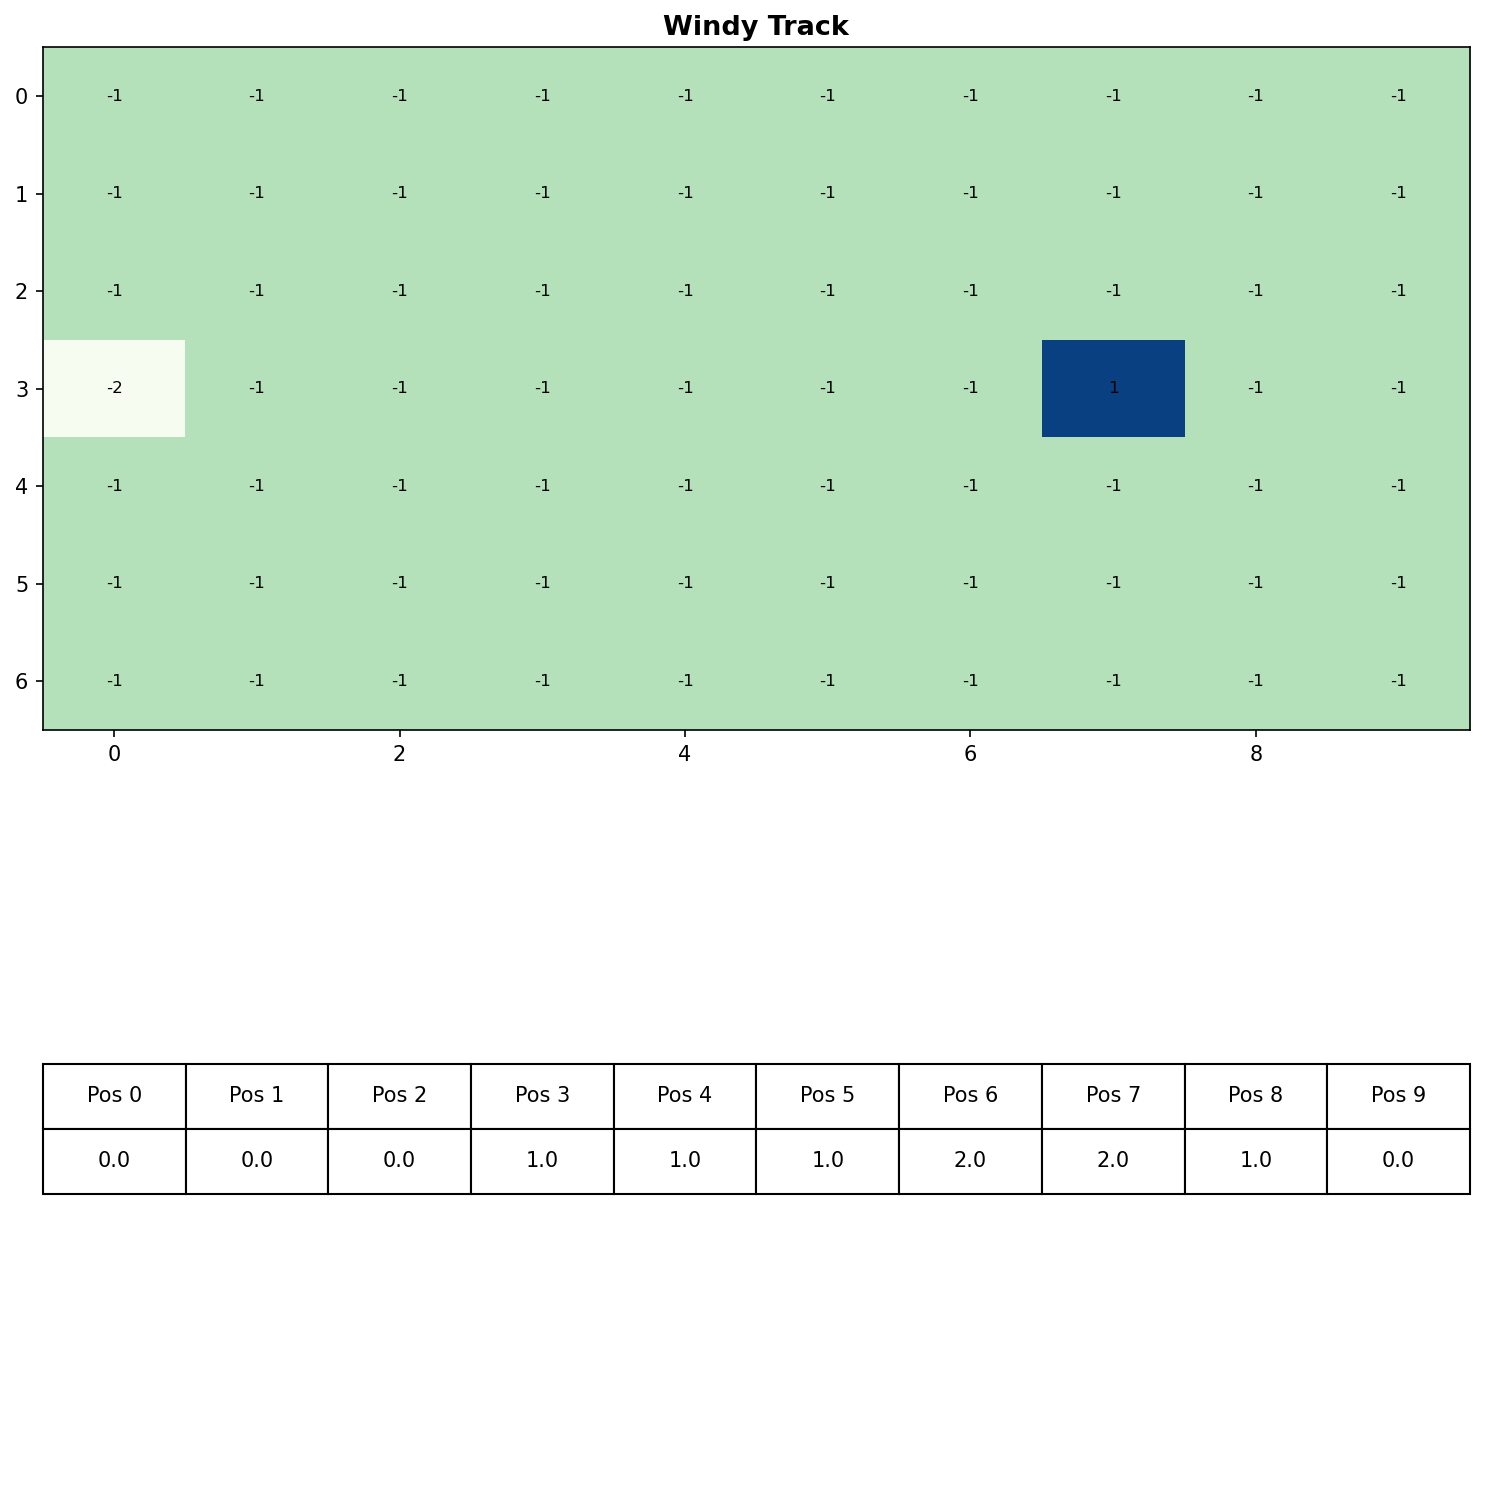

In [64]:
def build_windy_track(save_map=False):
    track = - np.ones(shape=(7, 10))
    track[3][0] = STARTING
    track[3][7] = FINISHING

    wind = np.zeros(10)
    wind[3:9] = 1
    wind[6:8] = 2
    if save_map:
        with open('./tracks/track_windy.npy', 'wb') as f:
            np.save(f, track)
    return track, wind

track_windy, wind_list = build_windy_track(save_map=True)

# Plotting the track and wind
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), dpi=150)

# Plotting the track
with open('./tracks/track_windy.npy', 'rb') as f:
    A = np.load(f)

cax = ax1.imshow(A, cmap='GnBu', aspect='auto')
ax1.set_title('Windy Track', fontdict={'fontsize': 13, 'fontweight': 'bold'})

# Annotate each cell with its value
for (j, k), val in np.ndenumerate(A):
    ax1.text(k, j, f'{int(val)}', ha='center', va='center', color='black', fontsize=8)

# Plotting the wind as a table of values
ax2.axis('tight')
ax2.axis('off')
table_data = [wind_list.tolist()]
col_labels = [f'Pos {i}' for i in range(10)]
table = ax2.table(cellText=table_data, colLabels=col_labels, cellLoc='center', loc='center')
table.scale(1, 2)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.3)

plt.tight_layout()
plt.savefig('maps.png')
plt.show()

In [65]:
class Windy_track_env():
    def __init__(self,track,wind):
        self.racetrack = np.copy(track)
        self.starting_line = self.get_starting_line()
        self.car_pos = self.get_starting_pos()
        self.wind = np.copy(wind)
    def get_pos(self):
        return self.car_pos
    
    def get_starting_pos(self):
        return random.choice(self.starting_line)
    
    def get_starting_line(self):
        starting_line = []
        for col in range(self.racetrack.shape[0]):
            for row in range(self.racetrack.shape[1]):
                if self.racetrack[col][row] == STARTING:
                    starting_line.append([col,row])
        return starting_line
    
    def start_again(self):
        self.car_pos = self.get_starting_pos()
        return (self.car_pos)
    
    def check_win(self,final_pos):
        col , row = final_pos
        if self.racetrack[col][row] == FINISHING:
            return True
        return False
    
    def check_valid(self, final_pos):
        col , row = final_pos
        if self.racetrack.shape[0] <= col or self.racetrack.shape[1] <= row :
            return False
        if col < 0 or row < 0:
            return False
        return True

    def take_step(self, action):
        #sofre a ventania
        wind_intensity = int(self.wind[self.car_pos[1]])
        
        if wind_intensity > 0:
            for i in range(wind_intensity):
                new_pos = [self.car_pos[0] - 1 , self.car_pos[1] ]
                if self.check_valid(new_pos):
                    self.car_pos = new_pos
                else:
                    break

        #actions: up[-1][] , down[+1][], left[][-1], right[][+1]
        if action == 'up':
            new_pos = [self.car_pos[0] - 1 , self.car_pos[1] ]
        elif action == 'down':
            new_pos = [self.car_pos[0] +1  , self.car_pos[1]]
        elif action == 'left':
            new_pos = [self.car_pos[0]   , self.car_pos[1] - 1]
        elif action == 'right':
            new_pos = [self.car_pos[0]   , self.car_pos[1] + 1]
            
        #checa se é válido 
        if self.check_valid(new_pos):
            self.car_pos = new_pos
            #checa se ganhou
            if self.check_win(new_pos):
                self.start_again()
                return [FINISHING,new_pos]
        return [TRACK,self.car_pos]


In [66]:
env = Windy_track_env(track_windy,wind_list)

#testes
#print(env.check_valid([6,10]))
#print(env.check_valid([0,0]))
#print(env.check_valid([-1,9]))
#print(env.check_win([6,9]))
#print(env.check_win([3,7]))
#print(env.starting_line)

In [67]:

class Agent_Sarsa:
    def __init__(self,race):
        self.race = race
        self.track = np.copy(race.racetrack)
        self.car_pos = race.get_pos()
        self.steps_trained = 0
        self.possible_actions = ('up','down','left','right')
        self.Q = self.intialize_Q()
        self.pi = self.intialize_pi()

    #inicializa Q para todo par estado-ação
    def intialize_Q(self):
        Q = {}
        for col in range(self.race.racetrack.shape[0]):
            for row in range(self.race.racetrack.shape[1]):
                    Q[(col,row)] = {}
                    for action in self.possible_actions:
                        Q[(col,row)][action] = 0
        return Q
    
    def intialize_pi(self):
        pi = {}
        for col in range(self.race.racetrack.shape[0]):
            for row in range(self.race.racetrack.shape[1]):
                    pi[(col,row)] = (random.choice(self.possible_actions))
        return pi


    #decide que ação tomar
    def chose_action_e_greedy(self,epsilon):
        random_value = random.random()
        self.car_pos = self.race.get_pos()
        state = tuple([self.car_pos[0],self.car_pos[1]])

        if random_value < epsilon:
            action = random.choice(self.possible_actions)
        #exploita com probailidade 1 - epsilon    
        else:
            action = self.pi[state]
        return state,action

    def update_pi(self):
        for state in self.Q:
            max_q_value = max(self.Q[state].values())
            max_actions = [action for action, q_value in self.Q[state].items() if q_value == max_q_value]
            self.pi[state] = random.choice(max_actions)



    def generate_pi_episode(self):
        states,actions, rewards = [], [] ,[]
        self.race.start_again()  # Reset the environment
        self.car_pos = self.race.get_pos()
        count = 0
        while True:
            state = tuple([self.car_pos[0],self.car_pos[1]])
            action = self.pi[state]
            states.append(tuple(self.car_pos))
            actions.append(action)
            reward, pos_speed = self.race.take_step(action)
            self.car_pos = pos_speed
            rewards.append(reward)
            count += 1
            if reward == FINISHING:
                print('number of actions taken:')
                print(count)
                self.generate_render_episode(states)
                return list(zip(states,actions, rewards))


      
    def generate_render_episode(self, states):
        track = np.copy(self.track)
        for state in states:
            if state[0] >= track.shape[0] or state[1] >= track.shape[1]:
                print(f"Index out of bounds: state[0] = {state[0]}, state[1] = {state[1]}")
            else:
                track[state[0]][state[1]] = -3
        
        fig, ax = plt.subplots(figsize=(8, 6))  # Ajuste o tamanho conforme necessário
        ax.imshow(track, cmap='GnBu')
        ax.set_title('Track', fontdict={'fontsize': 13, 'fontweight': 'bold'})
        plt.tight_layout()
        plt.show()

    #treina o modelos por x episodios
    def train(self, episodes,epsilon,alpha, gamma ):
        start_time = time.time()
        previous_time = start_time
        
        for episode in range(episodes):
            self.race.start_again()
            self.car_pos = self.race.get_pos()
            finished = False

            if episode % 10 == 0 and episode != 0:
                current_time = time.time()
                time_difference = current_time - previous_time
                episodes_per_second = 10 / time_difference                
                elapsed_time = current_time - start_time
                estimated_total_time = (elapsed_time / episode) * episodes
                remaining_time = estimated_total_time - elapsed_time

                print(f"Episode {episode}: {episodes_per_second:.2f} episodes/second, "
                    f"Elapsed time = {elapsed_time:.2f} seconds, "
                    f"Estimated time remaining = {remaining_time:.2f} seconds", end='\r')
                
                previous_time = current_time

            states = []
            actions = []
            rewards = []
            
            state, action = self.chose_action_e_greedy(epsilon)
            actions.append(state)
            actions.append(action)

            while not finished:
                
                reward, new_state = self.race.take_step(action)

                new_state, new_action = self.chose_action_e_greedy(epsilon)
                
                if reward == FINISHING:
                    finished = True
                    self.race.start_again()
                    break

                self.Q[state][action] += alpha * (reward + gamma * self.Q[new_state][new_action] - self.Q[state][action] )
                self.update_pi()
                
                state = new_state
                action = new_action      


In [68]:
env = Windy_track_env(track_windy,wind_list)
agent= Agent_Sarsa(env)

In [69]:
print(agent.Q)
print(agent.pi)

{(0, 0): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (0, 1): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (0, 2): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (0, 3): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (0, 4): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (0, 5): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (0, 6): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (0, 7): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (0, 8): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (0, 9): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (1, 0): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (1, 1): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (1, 2): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (1, 3): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (1, 4): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (1, 5): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (1, 6): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (1, 7): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (1, 8): {'up': 0, 'down': 0, 'left': 0, 'righ

In [70]:
ALPHA = 0.1
agent.train(3000,EPSILON,ALPHA,GAMMA)

In [71]:
print(agent.Q)
print(agent.pi)

{(0, 0): {'up': -9.919522763514536, 'down': -9.922181673538828, 'left': -9.91852799151576, 'right': -9.909438249389801}, (0, 1): {'up': -9.909066122044406, 'down': -9.909607856632702, 'left': -9.923401563445314, 'right': -9.891326094942768}, (0, 2): {'up': -9.894267302731254, 'down': -9.884553790827228, 'left': -9.910709011820622, 'right': -9.844887356375567}, (0, 3): {'up': -9.830872429389508, 'down': -9.855384209607328, 'left': -9.886939135076016, 'right': -9.794588483907637}, (0, 4): {'up': -9.783662991398309, 'down': -9.794733789956387, 'left': -9.844226022192798, 'right': -9.700900036092595}, (0, 5): {'up': -9.721453776887618, 'down': -9.73316689250406, 'left': -9.795883100853791, 'right': -9.636504924182901}, (0, 6): {'up': -9.615132103979297, 'down': -9.623048783401734, 'left': -9.717503730543726, 'right': -9.531567399661164}, (0, 7): {'up': -9.526728531536383, 'down': -9.535030551860894, 'left': -9.623478832631703, 'right': -9.431283747258659}, (0, 8): {'up': -9.391207880397257

number of actions taken:
15


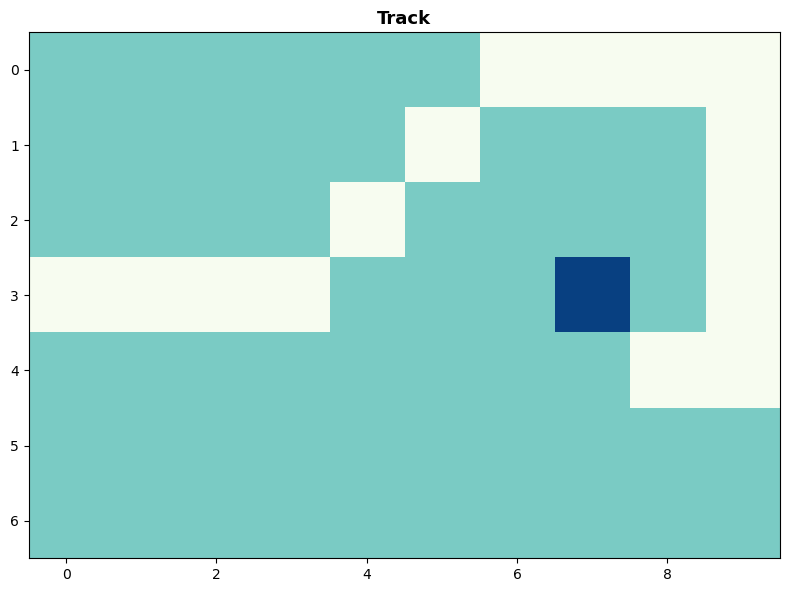

[((3, 0), 'right', -1),
 ((3, 1), 'right', -1),
 ((3, 2), 'right', -1),
 ((3, 3), 'right', -1),
 ((2, 4), 'right', -1),
 ((1, 5), 'right', -1),
 ((0, 6), 'right', -1),
 ((0, 7), 'right', -1),
 ((0, 8), 'right', -1),
 ((0, 9), 'down', -1),
 ((1, 9), 'down', -1),
 ((2, 9), 'down', -1),
 ((3, 9), 'down', -1),
 ((4, 9), 'left', -1),
 ((4, 8), 'left', 1)]

In [72]:
agent.generate_pi_episode()

In [73]:
class Agent_Qlearning:
    def __init__(self,race):
        self.race = race
        self.track = np.copy(race.racetrack)
        self.car_pos = race.get_pos()
        self.steps_trained = 0
        self.possible_actions = ('up','down','left','right')
        self.Q = self.intialize_Q()
        self.pi = self.intialize_pi()

    #inicializa Q para todo par estado-ação
    def intialize_Q(self):
        Q = {}
        for col in range(self.race.racetrack.shape[0]):
            for row in range(self.race.racetrack.shape[1]):
                    Q[(col,row)] = {}
                    for action in self.possible_actions:
                        Q[(col,row)][action] = 0
        return Q
    
    def intialize_pi(self):
        pi = {}
        for col in range(self.race.racetrack.shape[0]):
            for row in range(self.race.racetrack.shape[1]):
                    pi[(col,row)] = (random.choice(self.possible_actions))
        return pi


    #decide que ação tomar
    def chose_action_e_greedy(self,epsilon):
        random_value = random.random()
        self.car_pos = self.race.get_pos()
        state = tuple([self.car_pos[0],self.car_pos[1]])

        if random_value < epsilon:
            action = random.choice(self.possible_actions)
        #exploita com probailidade 1 - epsilon    
        else:
            action = self.pi[state]
        return state,action

    def update_pi(self):
        for state in self.Q:
            max_q_value = max(self.Q[state].values())
            max_actions = [action for action, q_value in self.Q[state].items() if q_value == max_q_value]
            self.pi[state] = random.choice(max_actions)



    def generate_pi_episode(self):
        states,actions, rewards = [], [] ,[]
        self.race.start_again() 
        self.car_pos = self.race.get_pos()
        count = 0
        while True:
            state = tuple([self.car_pos[0],self.car_pos[1]])
            action = self.pi[state]
            states.append(tuple(self.car_pos))
            actions.append(action)
            reward, pos_speed = self.race.take_step(action)
            self.car_pos = pos_speed
            rewards.append(reward)
            count += 1
            if reward == FINISHING:
                print('number of actions taken:')
                print(count)
                self.generate_render_episode(states)
                return list(zip(states,actions, rewards))
        
    def generate_render_episode(self, states):
        track = np.copy(self.track)
        for state in states:
            if state[0] >= track.shape[0] or state[1] >= track.shape[1]:
                print(f"Index out of bounds: state[0] = {state[0]}, state[1] = {state[1]}")
            else:
                track[state[0]][state[1]] = -3
        
        fig, ax = plt.subplots(figsize=(8, 6))  
        ax.imshow(track, cmap='GnBu')
        ax.set_title('Track', fontdict={'fontsize': 13, 'fontweight': 'bold'})
        plt.tight_layout()
        plt.show()

    def train(self, episodes,epsilon,alpha, gamma ):
        start_time = time.time()
        previous_time = start_time
        
        for episode in range(episodes):
            self.race.start_again()
            self.car_pos = self.race.get_pos()
            finished = False

            if episode % 10 == 0 and episode != 0:
                current_time = time.time()
                time_difference = current_time - previous_time
                episodes_per_second = 10 / time_difference                
                elapsed_time = current_time - start_time
                estimated_total_time = (elapsed_time / episode) * episodes
                remaining_time = estimated_total_time - elapsed_time

                print(f"Episode {episode}: {episodes_per_second:.2f} episodes/second, "
                    f"Elapsed time = {elapsed_time:.2f} seconds, "
                    f"Estimated time remaining = {remaining_time:.2f} seconds", end='\r')
                
                previous_time = current_time

            states = []
            actions = []
            rewards = []
            
            state, action = self.chose_action_e_greedy(epsilon)
            actions.append(state)
            actions.append(action)

            while not finished:

                reward, new_state = self.race.take_step(action)
                new_state_tuple = tuple(new_state)

                max_q_value = max(self.Q[new_state_tuple].values())
                max_actions = [action for action, q_value in self.Q[new_state_tuple].items() if q_value == max_q_value]
                
                max_next_action = random.choice(max_actions)
                
                if reward == FINISHING:
                    finished = True
                    self.race.start_again()
                    break
                
                self.Q[state][action] += alpha * (reward + gamma * max_q_value - self.Q[state][action])
                self.update_pi()
                
                state = new_state_tuple
                action = max_next_action

In [74]:
env2 = Windy_track_env(track_windy,wind_list)
agent2 = Agent_Qlearning(env2)

In [75]:
print(agent.Q)
print(agent.pi)

{(0, 0): {'up': -9.919522763514536, 'down': -9.922181673538828, 'left': -9.91852799151576, 'right': -9.909438249389801}, (0, 1): {'up': -9.909066122044406, 'down': -9.909607856632702, 'left': -9.923401563445314, 'right': -9.891326094942768}, (0, 2): {'up': -9.894267302731254, 'down': -9.884553790827228, 'left': -9.910709011820622, 'right': -9.844887356375567}, (0, 3): {'up': -9.830872429389508, 'down': -9.855384209607328, 'left': -9.886939135076016, 'right': -9.794588483907637}, (0, 4): {'up': -9.783662991398309, 'down': -9.794733789956387, 'left': -9.844226022192798, 'right': -9.700900036092595}, (0, 5): {'up': -9.721453776887618, 'down': -9.73316689250406, 'left': -9.795883100853791, 'right': -9.636504924182901}, (0, 6): {'up': -9.615132103979297, 'down': -9.623048783401734, 'left': -9.717503730543726, 'right': -9.531567399661164}, (0, 7): {'up': -9.526728531536383, 'down': -9.535030551860894, 'left': -9.623478832631703, 'right': -9.431283747258659}, (0, 8): {'up': -9.391207880397257

In [78]:
ALPHA = 0.1
agent2.train(3000,EPSILON,ALPHA,0.9)

number of actions taken:
15


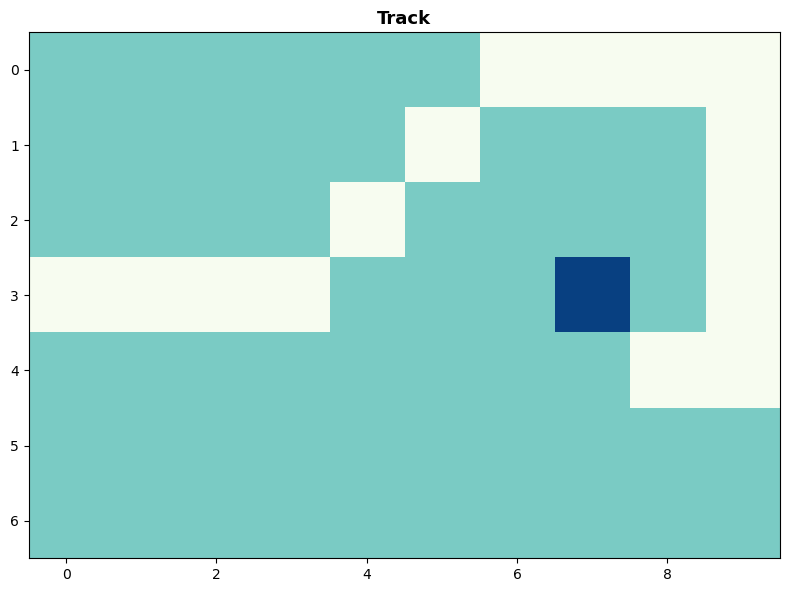

[((3, 0), 'right', -1),
 ((3, 1), 'right', -1),
 ((3, 2), 'right', -1),
 ((3, 3), 'right', -1),
 ((2, 4), 'right', -1),
 ((1, 5), 'right', -1),
 ((0, 6), 'right', -1),
 ((0, 7), 'right', -1),
 ((0, 8), 'right', -1),
 ((0, 9), 'down', -1),
 ((1, 9), 'down', -1),
 ((2, 9), 'down', -1),
 ((3, 9), 'down', -1),
 ((4, 9), 'left', -1),
 ((4, 8), 'left', 1)]

In [77]:
agent2.generate_pi_episode()